In [36]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground
from photutils.utils import calc_total_error

In [37]:
#data path
#dpath='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_R'
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrCandNearby'

#file name
fname='F0595_FO_IMA_0701893_FORF253_CAL_0283-0303_FIELD_3.fits'

#Name of field
field='Field3'

#wavelength of data
wavelength=25.2

In [38]:
#change directory to data location
os.chdir(dpath)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

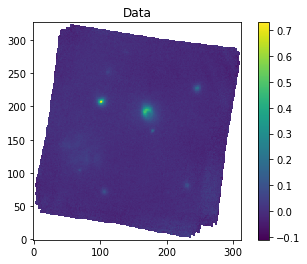

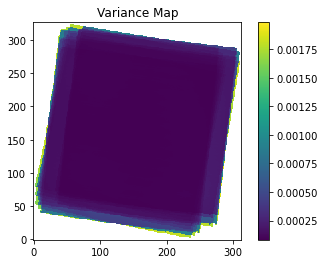

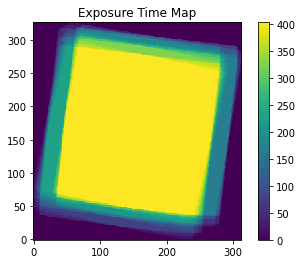

In [39]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

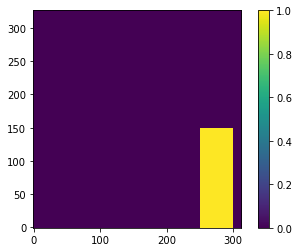

In [40]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:150,250:300]=1 
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [41]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(16, 16), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

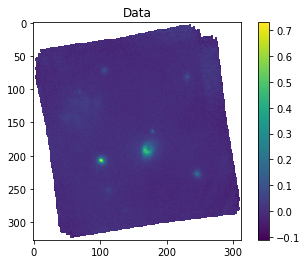

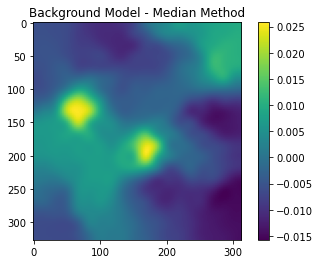

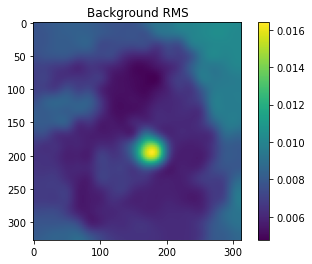

In [42]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [43]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

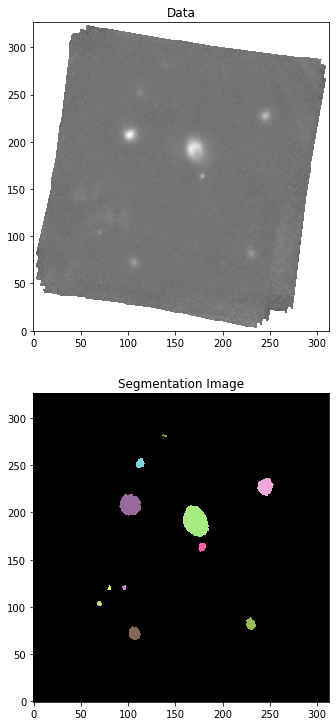

In [44]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [45]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,106.66342050712325,72.07810927261058,"266.26325914921,-29.29376033773766",0.01319560426610178,-0.005580019432100486,-0.7198225067409627,129.0,2.90945249530462,2.5374672685270374,-62.271163481872534,0.14726173417690824,0.03062148652522624,0.1261828458069107,0.48924575328589404,0.12785403005476315,1.1465970542325514,6.428195928346469,7.631461426008778,nan,1.700121329765864,5.827444226336008,nan
2,229.93255943252018,81.88133688522667,"266.2331062287022,-29.29166769307161",0.007034579201922037,5.909348246724244e-05,0.006677563518798396,113.0,2.9626449591453654,2.298908691797779,-74.68339383270502,0.18396232074490243,0.038360601072397756,0.11918381625605624,0.6307760087499678,0.22403503507860578,1.2887179772366406,6.244103264366881,7.410955743865921,nan,1.896223754274654,5.061895700886334,nan
3,69.8458728758479,103.91052935523987,"266.2722640148262,-29.286968494385764",-0.0062636486808411145,0.01122202055369636,0.2244404110739272,20.0,1.153081296002333,1.0514994628161287,-60.553684055403394,0.8676279988835477,0.13043064673170326,0.788924323946541,0.41040354338507634,0.08809598554619058,1.0966066429688395,2.598449541385307,1.6406965744100463,nan,2.4777749128259963,0.8879022017439563,nan
4,79.83081479226837,119.88358059212278,"266.26982119155576,-29.283561221702225",-0.00420132569101926,0.019354869503968822,0.32903278156746996,17.0,1.535829086855069,0.8873733617352062,74.11981214296246,1.2066102769480702,-0.4453083899260251,0.4872910793325499,0.8161916091026943,0.4222186769803348,1.730758610842054,2.9534937748868924,4.162203463806374,nan,3.5925802957676316,0.5234979213811003,nan
5,95.76212540630773,120.56664515055357,"266.26592454316807,-29.283415905931214",-0.003746290541867095,0.010183781594068865,0.18330806869323957,18.0,1.5692582046343924,0.9713496941437045,86.44749193193634,1.0573505342671257,-0.08086510491719784,0.4085897662002256,0.7854015998263034,0.3810134678441839,1.6155440353721173,3.073058898531017,4.23205763553843,nan,3.6736643289879,0.44476182755772364,nan
6,178.6330039436651,163.41234072602074,"266.2456559640407,-29.274275772342396",0.020153242511783215,0.007539181452110898,0.3920374355097667,52.0,1.8335822499565868,1.4389471629336095,63.38339278363618,0.44572157717182603,-0.14861540821920136,0.33467735662903525,0.6197823881381908,0.2152262801585917,1.2742526599923427,3.8810237752247234,5.090118391918441,nan,2.3151909844472716,3.297550347558652,nan
7,170.77206381631115,191.70987303307467,"266.2475788677177,-29.26823907004762",0.005765573543901717,0.022057011299168126,14.557627457450963,660.0,6.464058086320374,5.130498230535711,-67.6387427084128,0.035956219589573714,0.00989255657067758,0.02596737596600323,0.6083143668459914,0.20630381688661215,1.259927943810131,13.74154617216628,111.27701789230926,nan,1.578938994588865,96.51088005744305,nan
8,102.15308435290672,207.42600128184077,"266.2643594923013,-29.264886040844246",-0.0021198713541675167,0.007262350442292633,2.941251929128516,405.0,3.9723811213011246,3.9246076296021473,8.241843526271568,0.06340400981746089,-0.00044043147575108477,0.06489243760626734,0.15462273206660063,0.01202641192779852,1.0121728071205478,9.298163842919381,49.66359260631675,nan,1.3396504696713882,47.92849385251667,nan


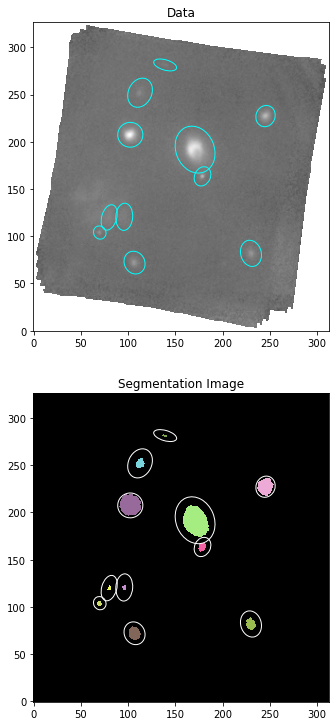

In [46]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

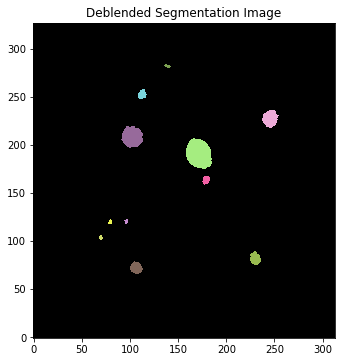

In [47]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [48]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,106.66342050712325,72.07810927261058,"266.26325914921,-29.29376033773766",0.01319560426610178,-0.005580019432100486,-0.7198225067409627,129.0,2.90945249530462,2.5374672685270374,-62.271163481872534,0.14726173417690824,0.03062148652522624,0.1261828458069107,0.48924575328589404,0.12785403005476315,1.1465970542325514,6.428195928346469,7.631461426008778,nan,1.700121329765864,5.827444226336008,nan
2,229.93255943252018,81.88133688522667,"266.2331062287022,-29.29166769307161",0.007034579201922037,5.909348246724244e-05,0.006677563518798396,113.0,2.9626449591453654,2.298908691797779,-74.68339383270502,0.18396232074490243,0.038360601072397756,0.11918381625605624,0.6307760087499678,0.22403503507860578,1.2887179772366406,6.244103264366881,7.410955743865921,nan,1.896223754274654,5.061895700886334,nan
3,69.8458728758479,103.91052935523987,"266.2722640148262,-29.286968494385764",-0.0062636486808411145,0.01122202055369636,0.2244404110739272,20.0,1.153081296002333,1.0514994628161287,-60.553684055403394,0.8676279988835477,0.13043064673170326,0.788924323946541,0.41040354338507634,0.08809598554619058,1.0966066429688395,2.598449541385307,1.6406965744100463,nan,2.4777749128259963,0.8879022017439563,nan
4,79.83081479226837,119.88358059212278,"266.26982119155576,-29.283561221702225",-0.00420132569101926,0.019354869503968822,0.32903278156746996,17.0,1.535829086855069,0.8873733617352062,74.11981214296246,1.2066102769480702,-0.4453083899260251,0.4872910793325499,0.8161916091026943,0.4222186769803348,1.730758610842054,2.9534937748868924,4.162203463806374,nan,3.5925802957676316,0.5234979213811003,nan
5,95.76212540630773,120.56664515055357,"266.26592454316807,-29.283415905931214",-0.003746290541867095,0.010183781594068865,0.18330806869323957,18.0,1.5692582046343924,0.9713496941437045,86.44749193193634,1.0573505342671257,-0.08086510491719784,0.4085897662002256,0.7854015998263034,0.3810134678441839,1.6155440353721173,3.073058898531017,4.23205763553843,nan,3.6736643289879,0.44476182755772364,nan
6,178.6330039436651,163.41234072602074,"266.2456559640407,-29.274275772342396",0.020153242511783215,0.007539181452110898,0.3920374355097667,52.0,1.8335822499565868,1.4389471629336095,63.38339278363618,0.44572157717182603,-0.14861540821920136,0.33467735662903525,0.6197823881381908,0.2152262801585917,1.2742526599923427,3.8810237752247234,5.090118391918441,nan,2.3151909844472716,3.297550347558652,nan
7,170.77206381631115,191.70987303307467,"266.2475788677177,-29.26823907004762",0.005765573543901717,0.022057011299168126,14.557627457450963,660.0,6.464058086320374,5.130498230535711,-67.6387427084128,0.035956219589573714,0.00989255657067758,0.02596737596600323,0.6083143668459914,0.20630381688661215,1.259927943810131,13.74154617216628,111.27701789230926,nan,1.578938994588865,96.51088005744305,nan
8,102.15308435290672,207.42600128184077,"266.2643594923013,-29.264886040844246",-0.0021198713541675167,0.007262350442292633,2.941251929128516,405.0,3.9723811213011246,3.9246076296021473,8.241843526271568,0.06340400981746089,-0.00044043147575108477,0.06489243760626734,0.15462273206660063,0.01202641192779852,1.0121728071205478,9.298163842919381,49.66359260631675,nan,1.3396504696713882,47.92849385251667,nan


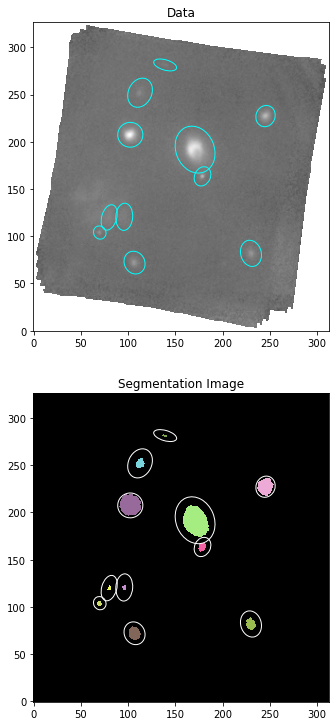

In [49]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [50]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [51]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [52]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,106.66342050712325,72.07810927261058,"266.26325914921,-29.29376033773766",0.01319560426610178,-0.005580019432100486,-0.7198225067409627,129.0,2.90945249530462,2.5374672685270374,-62.271163481872534,0.14726173417690824,0.03062148652522624,0.1261828458069107,0.48924575328589404,0.12785403005476315,1.1465970542325514,6.428195928346469,7.631461426008778,0.1936203739774029,1.700121329765864,5.827444226336008,0.107604004,-0.005457672096443811,-0.005539923245999475,0.0011092220342093925,17.764946698099653
2,229.93255943252018,81.88133688522667,"266.2331062287022,-29.29166769307161",0.007034579201922037,5.909348246724244e-05,0.006677563518798396,113.0,2.9626449591453654,2.298908691797779,-74.68339383270502,0.18396232074490243,0.038360601072397756,0.11918381625605624,0.6307760087499678,0.22403503507860578,1.2887179772366406,6.244103264366881,7.410955743865921,0.2147764449580749,1.896223754274654,5.061895700886334,0.10430987,5.415628825751066e-05,2.5267092056804868e-05,0.0004320229529083966,15.46274523358499
3,69.8458728758479,103.91052935523987,"266.2722640148262,-29.286968494385764",-0.0062636486808411145,0.01122202055369636,0.2244404110739272,20.0,1.153081296002333,1.0514994628161287,-60.553684055403394,0.8676279988835477,0.13043064673170326,0.788924323946541,0.41040354338507634,0.08809598554619058,1.0966066429688395,2.598449541385307,1.6406965744100463,0.11525439345975251,2.4777749128259963,0.8879022017439563,0.042650882,0.011247701045048075,0.011251481565241124,0.001139600293478615,1.7161559665858965
4,79.83081479226837,119.88358059212278,"266.26982119155576,-29.283561221702225",-0.00420132569101926,0.019354869503968822,0.32903278156746996,17.0,1.535829086855069,0.8873733617352062,74.11981214296246,1.2066102769480702,-0.4453083899260251,0.4872910793325499,0.8161916091026943,0.4222186769803348,1.730758610842054,2.9534937748868924,4.162203463806374,0.17669730482383925,3.5925802957676316,0.5234979213811003,0.03927117,0.01985082188056619,0.01990005997097476,0.001111260362736,0.8519516793436975
5,95.76212540630773,120.56664515055357,"266.26592454316807,-29.283415905931214",-0.003746290541867095,0.010183781594068865,0.18330806869323957,18.0,1.5692582046343924,0.9713496941437045,86.44749193193634,1.0573505342671257,-0.08086510491719784,0.4085897662002256,0.7854015998263034,0.3810134678441839,1.6155440353721173,3.073058898531017,4.23205763553843,0.19080364986078927,3.6736643289879,0.44476182755772364,0.04037938,0.010319232205053283,0.010232107467943131,0.001044160402700422,0.9385640260718483
6,178.6330039436651,163.41234072602074,"266.2456559640407,-29.274275772342396",0.020153242511783215,0.007539181452110898,0.3920374355097667,52.0,1.8335822499565868,1.4389471629336095,63.38339278363618,0.44572157717182603,-0.14861540821920136,0.33467735662903525,0.6197823881381908,0.2152262801585917,1.2742526599923427,3.8810237752247234,5.090118391918441,0.15509193135179578,2.3151909844472716,3.297550347558652,0.06697999,0.007412987118022023,0.00720292882869298,0.001775170396465677,4.962610624633783
7,170.77206381631115,191.70987303307467,"266.2475788677177,-29.26823907004762",0.005765573543901717,0.022057011299168126,14.557627457450963,660.0,6.464058086320374,5.130498230535711,-67.6387427084128,0.035956219589573714,0.00989255657067758,0.02596737596600323,0.6083143668459914,0.20630381688661215,1.259927943810131,13.74154617216628,111.27701789230926,0.37434883

In [53]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [54]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,106.66342050708278,72.07810927259757,"266.26325914921,-29.29376033773766",1.9109403834025358,0.0437373771168424,4.746024185000686,0.08745522909789608,6.6048213877160045,0.13111862953007947,7.4903463007450615,0.17468381271367678,7.803944626340103,0.21830018340784677
2,229.93255943249392,81.88133688520077,"266.2331062287022,-29.29166769307161",1.732692977645894,0.04531526526299216,4.292321727059862,0.09060965926714373,6.143990778210595,0.13581309734872452,7.020446675250206,0.18095202260543455,7.446298067291549,0.22600760323760993
3,69.84587287579971,103.9105293552818,"266.2722640148262,-29.286968494385764",0.8972507679032602,0.04401919825655323,1.4493649556511394,0.08801668816282757,1.758451592768472,0.13199870167896843,2.105167304559064,0.17593363672919793,2.6174787291458137,0.21984977384166607
4,79.83081479231733,119.88358059216918,"266.26982119155576,-29.283561221702225",0.6130894972864698,0.0439682720026786,1.8359066254212923,0.08786928301490876,3.213830857943228,0.13170598128324196,4.3007706908157495,0.17552733792825398,5.530606942539537,0.2193616088645799
5,95.76212540620244,120.56664515056296,"266.26592454316807,-29.283415905931214",0.49402698923646404,0.0439316920500924,1.6075528571816022,0.08778284378864669,2.869435053429815,0.13156466119993374,3.9140511762874275,0.17530216005871055,4.845032240548786,0.21907269853701788
6,178.6330039437427,163.41234072599892,"266.2456559640407,-29.274275772342396",2.2395475589073373,0.04283631220481177,3.8038130280308375,0.08574228594983252,4.61164980221706,0.1287456436619602,5.315972833905453,0.17183933691760112,6.7353133239750225,0.2148700921920311
7,170.77206381629873,191.70987303314942,"266.2475788677177,-29.26823907004762",7.1916000207381305,0.042985721071204845,28.703527364027686,0.08589352872296427,55.24462664159586,0.12868726774733102,75.95753688958051,0.17146067400254975,89.8258843435024,0.21423934193571104
8,102.15308435302335,207.4260012818518,"266.2643594923013,-29.264886040844246",11.416126707203665,0.04362590622530978,28.27749875732704,0.08731169900987923,39.873736278608135,0.13105100131717046,46.30488346633832,0.1748400814631098,49.5049921264131,0.21853320750016753


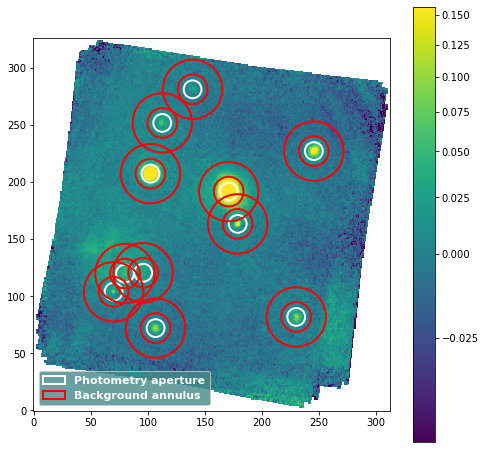

In [55]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture_in = SkyCircularAnnulus(sourcecoords, r_in=6*u.arcsec, r_out=12*u.arcsec) #define annulus small
annulus_aperture_out = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=20*u.arcsec) #define annulus large

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_ap_in = annulus_aperture_in.to_pixel(wcsmap)
pix_annulus_ap_out = annulus_aperture_out.to_pixel(wcsmap)

#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_ap_out.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [56]:
#now lets do robust statistics on the background annuli
appmasks_in=[]
appmasks_out=[]

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]

#create mask arrays for the annuli
annulus_masks_in = pix_annulus_ap_in.to_mask(method='exact')
annulus_masks_out = pix_annulus_ap_out.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks_in:
    annulus_data = mask.multiply(data_bkgsub)

    maskdata=mask.data
    
    #print(np.shape(annulus_data))
    #print(np.shape(maskdata))
    #print("\n")
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    #appmasks_in.append(mask.data)

#store values in numpy arrays
bkg_median_in = np.array(bkg_median)
bkg_mean_in = np.array(bkg_mean)
bkg_std_in = np.array(bkg_std)

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks_out:
    annulus_data = mask.multiply(data_bkgsub)
    
    maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    #appmasks_out.append(mask.data)

#store values in numpy arrays
bkg_median_out = np.array(bkg_median)
bkg_mean_out = np.array(bkg_mean)
bkg_std_out = np.array(bkg_std)

In [57]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['annsm_bkg_med'] = bkg_median_in
phot_table2['annsm_bkg_mean'] = bkg_mean_in 
phot_table2['annlg_bkg_med'] = bkg_median_out
phot_table2['annlg_bkg_mean'] = bkg_mean_out 

#move this to later
#phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
#phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture using smaller annulus
skynoise_sap=np.sqrt(phot_table2['annsm_bkg_med']*pix_aperture.area)
sna=np.array(skynoise_sap)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise_sap=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix_sm']=skynoise_sap/pix_aperture.area

#calculate sky noise for 6 pixel aperture using larger annulus
skynoise_lap=np.sqrt(phot_table2['annlg_bkg_med']*pix_aperture.area)
sna=np.array(skynoise_lap)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise_lap=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix_lg']=skynoise_lap/pix_aperture.area


#do the SNR calcs later...
#shot noise from the source
#sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
#thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
#totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
#phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-57-6428622f4761>:26: RuntimeWarning: invalid value encountered in sqrt
  skynoise_lap=np.sqrt(phot_table2['annlg_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,106.66342050708278,72.07810927259757,"266.26325914921,-29.29376033773766",6.6048213877160045,0.13111862953007947,0.0012334110955536126,0.0017013070476025046,-0.0007105865714274215,-0.0011872185101743414,0.0012334110955536123,0.0
2,229.93255943249392,81.88133688520077,"266.2331062287022,-29.29166769307161",6.143990778210595,0.13581309734872452,0.0013727737559207254,0.0017724704585160807,0.00014541107702327694,0.00011058024088586815,0.0013727737559207256,0.00014541107702327696
3,69.84587287579971,103.9105293552818,"266.2722640148262,-29.286968494385764",1.758451592768472,0.13199870167896843,0.0011081249549860664,0.0021511902210546653,0.0007029509254714601,0.0016547203774455019,0.0011081249549860664,0.0007029509254714601
4,79.83081479231733,119.88358059216918,"266.26982119155576,-29.283561221702225",3.213830857943228,0.13170598128324196,0.005085825875218792,0.005842047397252364,0.0031746431241342294,0.0038511619425873056,0.005085825875218792,0.0031746431241342294
5,95.76212540620244,120.56664515056296,"266.26592454316807,-29.283415905931214",2.869435053429815,0.13156466119993374,0.0035610835017891845,0.004217340785424601,0.001518226400366233,0.002283689390524217,0.003561083501789184,0.0015182264003662331
6,178.6330039437427,163.41234072599892,"266.2456559640407,-29.274275772342396",4.61164980221706,0.1287456436619602,0.002026676466370041,0.0034036733449120124,0.0002821518799040397,0.0009440478623864882,0.0020266764663700414,0.0002821518799040397
7,170.77206381629873,191.70987303314942,"266.2475788677177,-29.26823907004762",55.24462664159586,0.12868726774733102,0.05600256186082491,0.06380221324428677,0.010224929611293437,0.012053242760157111,0.05600256186082491,0.010224929611293435
8,102.15308435302335,207.4260012818518,"266.2643594923013,-29.264886040844246",39.873736278608135,0.13105100131717046,0.012557731545916672,0.01648670097328236,3.3815333720247204e-05,0.0004065530024374187,0.01255773154591667,3.381533372024721e-05


In [58]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [59]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['annsm_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['annsm_bkg_med'])*ap4area
merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['annlg_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['annlg_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['annlg_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix_sm']*ap2area)*(1+ap2area/pix_annulus_ap_in.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix_sm']*ap4area)*(1+ap4area/pix_annulus_ap_in.area))
merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix_lg']*ap6area)*(1+ap6area/pix_annulus_ap_out.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix_lg']*ap8area)*(1+ap8area/pix_annulus_ap_out.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix_lg']*ap10area)*(1+ap10area/pix_annulus_ap_out.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_6as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_6as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,106.66342050712325,72.07810927261058,"266.26325914921,-29.29376033773766",0.01319560426610178,-0.005580019432100486,-0.7198225067409627,129.0,2.90945249530462,2.5374672685270374,-62.271163481872534,0.14726173417690824,0.03062148652522624,0.1261828458069107,0.48924575328589404,0.12785403005476315,1.1465970542325514,6.428195928346469,7.631461426008778,0.1936203739774029,1.700121329765864,5.827444226336008,0.107604004,-0.005457672096443811,-0.005539923245999475,0.0011092220342093925,17.764946698099653,1.9109403834025358,0.0437373771168424,4.746024185000686,0.08745522909789608,6.6048213877160045,0.13111862953007947,7.4903463007450615,0.17468381271367678,7.803944626340103,0.21830018340784677,0.0012334110955536126,0.0017013070476025046,-0.0007105865714274215,-0.0011872185101743414,0.0012334110955536123,0.0,1.8846622043554406,4.6409114688123045,6.741074653944691,7.73257432959606,8.182425921419789,6.994217219778671,9.869890187065185,17.590894532844864,16.79607122725185,15.166510271452518,17.590894532844864,C7Field3,25.2
2,229.93255943252018,81.88133688522667,"266.2331062287022,-29.29166769307161",0.007034579201922037,5.909348246724244e-05,0.006677563518798396,113.0,2.9626449591453654,2.298908691797779,-74.68339383270502,0.18396232074490243,0.038360601072397756,0.11918381625605624,0.6307760087499678,0.22403503507860578,1.2887179772366406,6.244103264366881,7.410955743865921,0.2147764449580749,1.896223754274654,5.061895700886334,0.10430987,5.415628825751066e-05,2.5267092056804868e-05,0.0004320229529083966,15.46274523358499,1.732692977645894,0.04531526526299216,4.292321727059862,0.09060965926714373,6.143990778210595,0.13581309734872452,7.020446675250206,0.18095202260543455,7.446298067291549,0.22600760323760993,0.0013727737559207254,0.0017724704585160807,0.00014541107702327694,0.00011058024088586815,0.0013727737559207256,0.00014541107702327696,1.7034456369342015,4.175332364213093,6.116108553880838,6.970878276441748,7.368847444153334,6.125909908405719,8.552231244362273,14.283940743058157,13.180829199973418,11.584591912428404,14.283940743058157,C7Field3,25.2
3,69.8458728758479,103.91052935523987,"266.2722640148262,-29.286968494385764",-0.0062636486808411145,0.01122202055369636,0.2244404110739272,20.0,1.153081296002333,1.0514994628161287,-60.553684055403394,0.8676279988835477,0.13043064673170326,0.788924323946541,0.41040354338507634,0.08809598554619058,1.0966066429688395,2.598449541385307,1.6406965744100463,0.11525439345975251,2.4777749128259963,0.8879022017439563,0.042650882,0.011247701045048075,0.011251481565241124,0.001139600293478615,1.7161559665858965,0.8972507679032602,0.04401919825655323,1.4493649556511394,0.08801668816282757,1.

In [60]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [66]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
#fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
#keepconditions=(snrcut&fwhmcut) #conditions to keep a source
#mtcut=merged_table_2[keepconditions] #apply conditions
mtcut=merged_table_2[snrcut] #apply only snr cut

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,annsm_bkg_med,annsm_bkg_mean,annlg_bkg_med,annlg_bkg_mean,skynoise_pix_sm,skynoise_pix_lg,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_6as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_6as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,106.66342050712325,72.07810927261058,"266.26325914921,-29.29376033773766",0.01319560426610178,-0.005580019432100486,-0.7198225067409627,129.0,2.90945249530462,2.5374672685270374,-62.271163481872534,0.14726173417690824,0.03062148652522624,0.1261828458069107,0.48924575328589404,0.12785403005476315,1.1465970542325514,6.428195928346469,7.631461426008778,0.1936203739774029,1.700121329765864,5.827444226336008,0.107604004,-0.005457672096443811,-0.005539923245999475,0.0011092220342093925,17.764946698099653,1.9109403834025358,0.0437373771168424,4.746024185000686,0.08745522909789608,6.6048213877160045,0.13111862953007947,7.4903463007450615,0.17468381271367678,7.803944626340103,0.21830018340784677,0.0012334110955536126,0.0017013070476025046,-0.0007105865714274215,-0.0011872185101743414,0.0012334110955536123,0.0,1.8846622043554406,4.6409114688123045,6.741074653944691,7.73257432959606,8.182425921419789,6.994217219778671,9.869890187065185,17.590894532844864,16.79607122725185,15.166510271452518,17.590894532844864,C7Field3,25.2
2,229.93255943252018,81.88133688522667,"266.2331062287022,-29.29166769307161",0.007034579201922037,5.909348246724244e-05,0.006677563518798396,113.0,2.9626449591453654,2.298908691797779,-74.68339383270502,0.18396232074490243,0.038360601072397756,0.11918381625605624,0.6307760087499678,0.22403503507860578,1.2887179772366406,6.244103264366881,7.410955743865921,0.2147764449580749,1.896223754274654,5.061895700886334,0.10430987,5.415628825751066e-05,2.5267092056804868e-05,0.0004320229529083966,15.46274523358499,1.732692977645894,0.04531526526299216,4.292321727059862,0.09060965926714373,6.143990778210595,0.13581309734872452,7.020446675250206,0.18095202260543455,7.446298067291549,0.22600760323760993,0.0013727737559207254,0.0017724704585160807,0.00014541107702327694,0.00011058024088586815,0.0013727737559207256,0.00014541107702327696,1.7034456369342015,4.175332364213093,6.116108553880838,6.970878276441748,7.368847444153334,6.125909908405719,8.552231244362273,14.283940743058157,13.180829199973418,11.584591912428404,14.283940743058157,C7Field3,25.2
3,69.8458728758479,103.91052935523987,"266.2722640148262,-29.286968494385764",-0.0062636486808411145,0.01122202055369636,0.2244404110739272,20.0,1.153081296002333,1.0514994628161287,-60.553684055403394,0.8676279988835477,0.13043064673170326,0.788924323946541,0.41040354338507634,0.08809598554619058,1.0966066429688395,2.598449541385307,1.6406965744100463,0.11525439345975251,2.4777749128259963,0.8879022017439563,0.042650882,0.011247701045048075,0.011251481565241124,0.001139600293478615,1.7161559665858965,0.8972507679032602,0.04401919825655323,1.4493649556511394,0.08801668816282757,1.

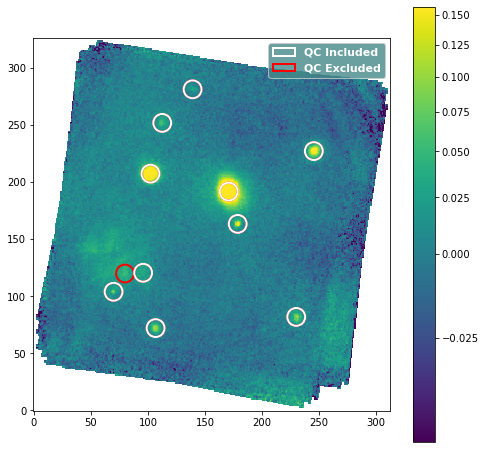

In [62]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

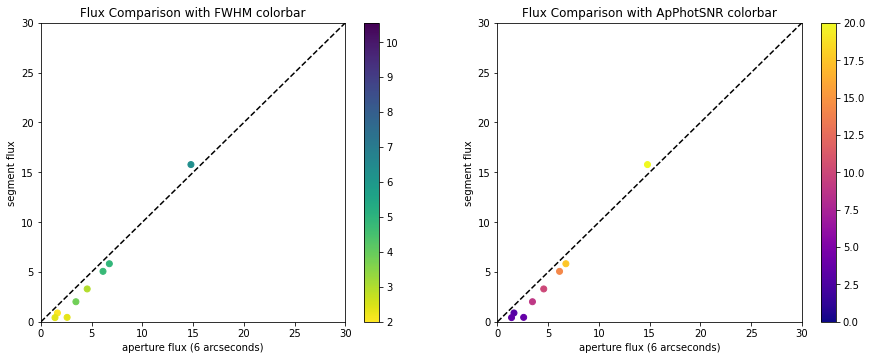

In [63]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

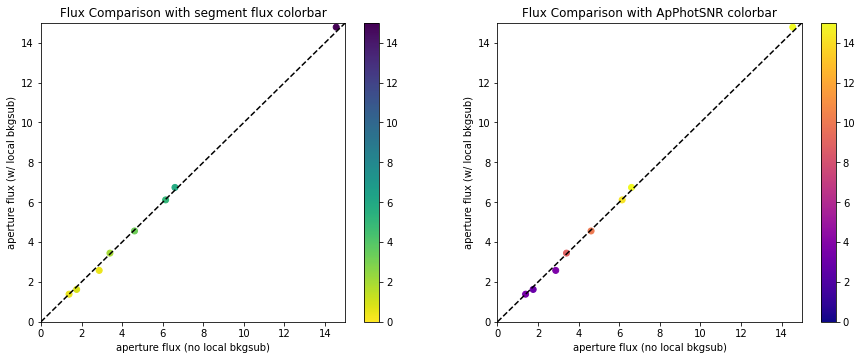

In [64]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [65]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)